In [8]:
import torch

# 检查是否有可用的GPU
print(torch.cuda.is_available())

# 输出当前使用的GPU设备
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset

# 加载Financial PhraseBank数据集
file_path = 'E:/Haibo_Fang23-24-Dissertation/report/FinancialPhraseBank-v1.0/Sentences_50Agree.txt'

# 加载数据并添加列名
df = pd.read_csv(file_path, delimiter='@', header=None, names=['sentence', 'sentiment'], encoding='ISO-8859-1')

# 去除空白符号
df['sentence'] = df['sentence'].str.strip()
df['sentiment'] = df['sentiment'].str.strip()

# 将情绪标签转换为数字
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

# 划分训练集和测试集
train_texts, test_texts, train_labels, test_labels = train_test_split(df['sentence'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42)


True
0
NVIDIA GeForce RTX 2060


In [9]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 加载预训练的BERT模型和tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)

def extract_features(texts, tokenizer, model, device, max_len=512):
    model.eval()
    features = []
    with torch.no_grad():
        for text in texts:
            inputs = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=max_len,
                return_token_type_ids=False,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            inputs = {key: val.to(device) for key, val in inputs.items()}  # 将输入张量移到同一个设备上
            outputs = model(**inputs)
            features.append(outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy())
    return features

train_features = extract_features(train_texts, tokenizer, model, device)
test_features = extract_features(test_texts, tokenizer, model, device)


Using device: cuda


              precision    recall  f1-score   support

    negative       0.79      0.34      0.47       110
     neutral       0.72      0.95      0.82       571
    positive       0.71      0.42      0.53       289

    accuracy                           0.72       970
   macro avg       0.74      0.57      0.61       970
weighted avg       0.73      0.72      0.69       970



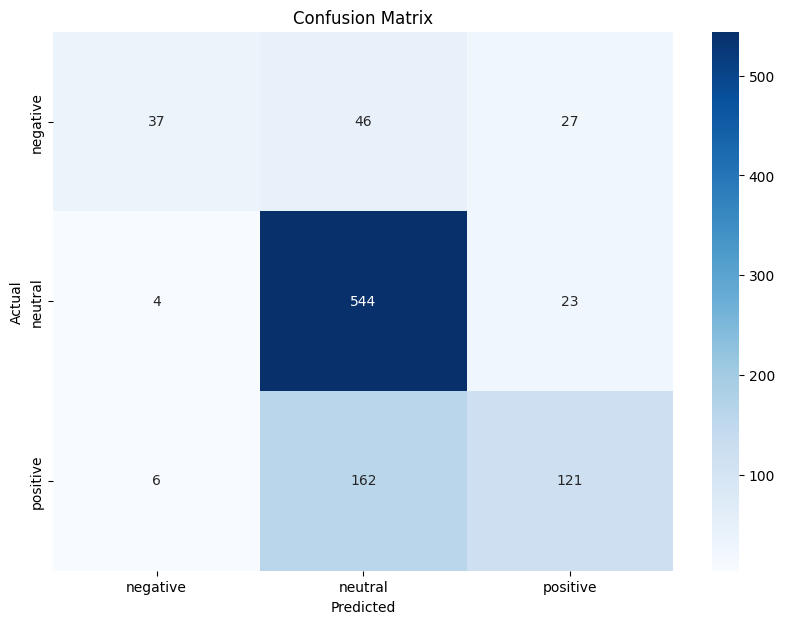

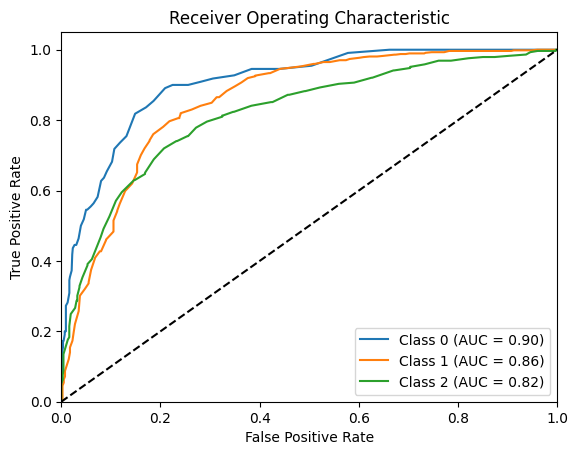

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 使用随机森林模型进行训练
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

# 预测
rf_predictions = rf_model.predict(test_features)

# 评估
print(classification_report(test_labels, rf_predictions, target_names=['negative', 'neutral', 'positive']))

# 混淆矩阵
cm = confusion_matrix(test_labels, rf_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 计算并绘制ROC和AUC
y_score = rf_model.predict_proba(test_features)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


Sentiment Summary: {1: 224, 2: 10}


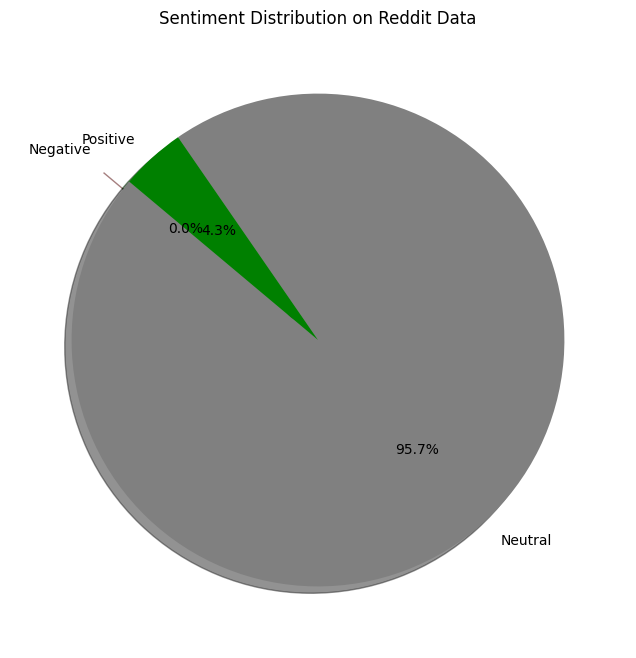

In [11]:
import praw
import numpy as np

# Reddit API 认证
reddit = praw.Reddit(client_id='ByGHuaBLiK2AdpNTPWKlCA',
                     client_secret='KfB9LAgGXaJ7PhUzRFvNZr32P3g5lg',
                     user_agent='Haibo Fang')

def get_reddit_data(stock_ticker):
    subreddit = reddit.subreddit('all')
    query = f'{stock_ticker}'
    posts = subreddit.search(query, limit=1000)
    data = []
    for post in posts:
        data.append(post.title + ' ' + post.selftext)
    return data

# 替换为你感兴趣的股票代码
stock_ticker = 'AAPL'
reddit_data = get_reddit_data(stock_ticker)

# 提取Reddit数据的特征
reddit_features = extract_features(reddit_data, tokenizer, model, device)

# 使用训练好的模型进行预测
reddit_predictions = rf_model.predict(reddit_features)

# 统计情绪分析结果
def summarize_sentiments(predictions):
    unique, counts = np.unique(predictions, return_counts=True)
    sentiment_summary = dict(zip(unique, counts))
    return sentiment_summary

summary = summarize_sentiments(reddit_predictions)
print("Sentiment Summary:", summary)

# 可视化情绪分析结果
labels = ['Negative', 'Neutral', 'Positive']
sizes = [summary.get(0, 0), summary.get(1, 0), summary.get(2, 0)]
colors = ['red', 'gray', 'green']
explode = (0.1, 0, 0)  # 使第一块（负面情绪）稍微分离出来

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Sentiment Distribution on Reddit Data')
plt.show()
